In [1]:
import heeps.util.img_processing as impro
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import os
import proper

In [2]:
os.chdir(os.path.normpath(os.path.expandvars('$HOME/heeps_metis/input_files/pupil')))
pupil = fits.getdata('eso/SegmentationPattern.fits')
spiders = fits.getdata('eso/SpiderShadow.fits')
print(type(pupil[0,0]))
print(np.any((0<pupil) * (pupil<1)))
print(np.any((0<spiders) * (spiders<1)))

<class 'numpy.uint8'>
False
False


(10526, 10526)

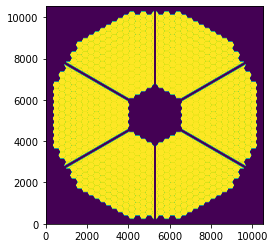

In [3]:
old_pupil = np.uint8(pupil.astype(bool) * spiders.astype(bool))
plt.imshow(old_pupil, origin='lower')
old_size = old_pupil.shape[0]
old_pupil.shape

(9094, 9094)

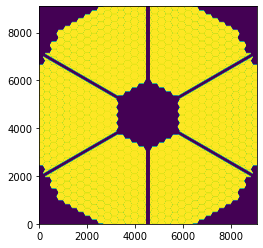

In [4]:
case = 'APP4pc'
if case == 'CFO': # vortex
    new_size = 9398
    diam_ext = 35.7124
    diam_int = 12.4078
    spider_width = 0.5
elif case == 'APP': # APP
    new_size = 9094
    diam_ext = 34.5572
    diam_int = 13.5641
    spider_width = 2.4271
elif case == 'APP4pc': # APP
    new_size = 9094
    diam_ext = 34.5572
    diam_int = 13.5641
    spider_width = 2.0417
    
crop = int((old_size - new_size)/2)
old_pupil_cropped = old_pupil[crop:-crop, crop:-crop]
plt.imshow(old_pupil_cropped, origin='lower')
old_pupil_cropped.shape

(9094, 9094)

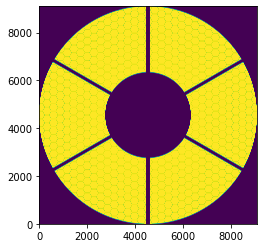

In [5]:
r_obsc = diam_int/diam_ext # obscuration ratio
dn = 2/new_size
pup_range = np.arange(-1, 1, dn) + dn/2
xi,yi = np.meshgrid(pup_range, pup_range)
zi = xi + 1j*yi
ri = np.abs(zi)
ti = np.angle(zi)
obscur = ((ri>=r_obsc) * (ri<=1)).astype(int)
new_pupil = obscur*old_pupil_cropped
plt.imshow(new_pupil, origin='lower')
new_pupil.shape

(9094, 9094)

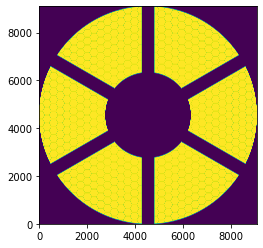

In [6]:
wf = proper.prop_begin(diam_ext, 1, new_size, 1)
proper.prop_multiply(wf, new_pupil)
for angle in [0, 60, 120]:
    proper.prop_rectangular_obscuration(wf, spider_width, 2*diam_ext, ROTATION=angle)
new_pupil_spiders = proper.prop_get_amplitude(wf)
# normalize as type int
new_pupil_spiders /= np.max(new_pupil_spiders)
new_pupil_spiders = np.uint8(new_pupil_spiders)
plt.imshow(new_pupil_spiders, origin='lower')
new_pupil_spiders.shape

In [7]:
fits.writeto('ELT_binary_pupil_%s_%s.fits'%(new_size, case), new_pupil_spiders, overwrite=True)
npupil_L = 245
fits.writeto('ELT_pupil_L_%s_%s.fits'%(npupil_L, case), \
             impro.resize_img(np.float32(new_pupil_spiders), npupil_L), overwrite=True)
npupil_M = 195
fits.writeto('ELT_pupil_M_%s_%s.fits'%(npupil_M, case), \
             impro.resize_img(np.float32(new_pupil_spiders), npupil_M), overwrite=True)